In [155]:
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from tqdm import tqdm_notebook
from tqdm import tqdm
from collections import deque
from time import time

In [156]:
ROOT = "../PHBS_multi-factor_project/002 src/08 multiFactorModelPython"
sytleFactorDir = ROOT + "/bigDataProjectData/styleFactor/styleFactors_20191231.mat"
industryFactorDir = ROOT + "/bigDataProjectData/industryFactor/industryFactor_20191231.mat"
alphaFactorDir = ROOT + "/bigDataProjectData/orthFactorExposure/ortheFactors_20200102_2.mat"
closeDir = ROOT + "/bigDataProjectData/closeStock.mat"

In [157]:
# mat = io.loadmat('yourfile.mat')
alphaFactorMat = io.loadmat(alphaFactorDir)
print(alphaFactorMat.keys())
alphaFactorCube = alphaFactorMat['orthFactors'][0][0][0]
print('alphaFactorCube:', alphaFactorCube.shape)

sytleFactorMat = io.loadmat(sytleFactorDir)
print(sytleFactorMat.keys())
sytleFactorCube = sytleFactorMat['styleSTR'][0][0][1]
print('sytleFactorCube:', sytleFactorCube.shape)

industryFactorMat = h5py.File(industryFactorDir)
print(industryFactorMat.keys())
industryFactorCube = np.transpose(industryFactorMat['industryFactor'])
print('industryFactorCube:', industryFactorCube.shape)

closeMat = io.loadmat(closeDir)
print(closeMat.keys())
close = closeMat['close']
print('close:', close.shape)


dict_keys(['__header__', '__version__', '__globals__', 'orthFactors', '__function_workspace__'])
alphaFactorCube: (2166, 3842, 29)
dict_keys(['__header__', '__version__', '__globals__', 'styleSTR'])
sytleFactorCube: (2166, 3842, 9)


C:\Users\Evan\AppData\Local\conda\conda\envs\env_futures\lib\site-packages\ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':


<KeysViewHDF5 ['industryFactor']>
industryFactorCube: (2166, 3842, 34)
dict_keys(['__header__', '__version__', '__globals__', 'close'])
close: (2166, 3842)


In [158]:
returnTable = (pd.DataFrame(close)-pd.DataFrame(close).shift(1))/pd.DataFrame(close).shift(1)
returnTable.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841
2161,-0.017024,0.009720,NaN,NaN,-0.006780,0.005894,-0.001927,0.008850,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2162,0.013470,0.060718,NaN,NaN,0.006826,0.015625,-0.038610,0.023392,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2163,-0.011392,-0.010471,NaN,NaN,0.006780,-0.011538,0.027108,0.002857,-0.002232,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2164,-0.009603,-0.012346,NaN,NaN,-0.010101,0.000000,-0.017595,-0.005698,0.006711,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2165,0.001293,-0.007143,NaN,NaN,0.000000,-0.001946,-0.004975,-0.002865,-0.011111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
d_timeShift = -1
shiftedReturnTable = returnTable.shift(d_timeShift)
shiftedReturnTable.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841
2161,0.013470,0.060718,NaN,NaN,0.006826,0.015625,-0.038610,0.023392,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2162,-0.011392,-0.010471,NaN,NaN,0.006780,-0.011538,0.027108,0.002857,-0.002232,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2163,-0.009603,-0.012346,NaN,NaN,-0.010101,0.000000,-0.017595,-0.005698,0.006711,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2164,0.001293,-0.007143,NaN,NaN,0.000000,-0.001946,-0.004975,-0.002865,-0.011111,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Linear predictoin
## 1. simple linear one day





In [7]:
stockScreanTable = np.ones(returnTable.shape)
timeslice = 2161

X_industry = industryFactorCube[timeslice, :, :]
X_style = sytleFactorCube[timeslice, :, :]
X_alpha = alphaFactorCube[timeslice, :, :]
stockScrean = stockScreanTable[timeslice, :]

X_all = np.concatenate([X_industry, X_style, X_alpha], axis= 1)
y_shiftedReturn = shiftedReturnTable.loc[timeslice]
print("shape of X:", X_all.shape, "\nshape of y:", y_shiftedReturn.shape)

shape of X: (3842, 72) 
shape of y: (3842,)


In [8]:
toMask = np.concatenate([np.array(y_shiftedReturn).reshape(-1, 1), X_all],axis = 1)
finiteIndex = np.isfinite(toMask).all(axis = 1)
validIndex = np.logical_and(finiteIndex,  stockScrean.astype(bool))
validToCal = toMask[validIndex, :]


print("is there any inf:", np.isinf(validToCal).any())
print("is there any nan:",np.isnan(validToCal).any())
print("validToCal", validToCal.shape)

X = validToCal[:, 1:]
y = validToCal[:, 0]
print("X of ",timeslice , X.shape)
print("y of ",timeslice,  y.shape)

is there any inf: False
is there any nan: False
validToCal (3343, 73)
X of  2161 (3343, 72)
y of  2161 (3343,)


In [9]:
model = LinearRegression(fit_intercept=False, n_jobs = 5)
model.fit(X, y)

saveFactorReturn = True

if saveFactorReturn:
    todayFReturn = model.coef_

In [10]:
timeslice = timeslice+1

X_industry = industryFactorCube[timeslice, :, :]
X_style = sytleFactorCube[timeslice, :, :]
X_alpha = alphaFactorCube[timeslice, :, :]
stockScrean = stockScreanTable[timeslice, :]

X_all = np.concatenate([X_industry, X_style, X_alpha], axis= 1)
y_shiftedReturn = shiftedReturnTable.loc[timeslice]
print("shape of X:", X_all.shape, "\nshape of y:", y_shiftedReturn.shape)

toMask = np.concatenate([np.array(y_shiftedReturn).reshape(-1, 1), X_all],axis = 1)
finiteIndex = np.isfinite(toMask).all(axis = 1)
validIndex = np.logical_and(finiteIndex,  stockScrean.astype(bool))
validToCal = toMask[validIndex, :]


print("is there any inf:", np.isinf(validToCal).any())
print("is there any nan:",np.isnan(validToCal).any())
print("validToCal", validToCal.shape)

X = validToCal[:, 1:]
y = validToCal[:, 0]
print("X of ",timeslice , X.shape)
print("y of ",timeslice,  y.shape)
    
predictReturn = model.predict(X)



# predictReturn
np.corrcoef(predictReturn, y)[0,1]

shape of X: (3842, 72) 
shape of y: (3842,)
is there any inf: False
is there any nan: False
validToCal (3342, 73)
X of  2162 (3342, 72)
y of  2162 (3342,)


-0.0436896462929818

## 2. iter


In [34]:
toTestAlphaCube = alphaFactorCube[:, :, 17]
print(toTestAlphaCube.shape)

(2166, 3842)


In [66]:
isLinearModel = True
predictReturnTable = np.zeros(shiftedReturnTable.shape)

if isLinearModel:
    allXCount = X_industry.shape[-1] +X_style.shape[-1] +1
    factorReturnTable = np.zeros((shiftedReturnTable.shape[0], allXCount))
    
modelIC = np.zeros(shiftedReturnTable.shape[0])
backTestDays = 200

T = 1
modelQueue = deque(maxlen=T)

In [67]:
def getWeightExpectReturn(toWeightReturn):
    return(toWeightReturn.mean(0))

def getTimesliceData(timeslice, *args):
    output = []
    for cube in args:
        if np.ndim(cube)>2:
            output.append(cube[timeslice, :, :])
        else:
            output.append(cube[timeslice, :].reshape(-1,1))
    return(output)

In [147]:
for timeslice in tqdm_notebook(range(shiftedReturnTable.shape[0]-backTestDays, shiftedReturnTable.shape[0]-1)):
    
#     tqdm.write("start process:"+str(timeslice))
    starttime= time()
    X_industry, X_style, X_alpha = getTimesliceData(timeslice,industryFactorCube,sytleFactorCube, toTestAlphaCube)
#     alphaCount = X_alpha.shape[-1]
    alphaCount = 1
        
    stockScrean = stockScreanTable[timeslice, :]
    y_shiftedReturn = shiftedReturnTable.loc[timeslice]
    
    #mask to get valid datas(company):validToCal
    X_all = np.concatenate([X_industry, X_style, X_alpha], axis= 1)
    toMask = np.concatenate([np.array(y_shiftedReturn).reshape(-1, 1), X_all],axis = 1)
    finiteIndex = np.isfinite(toMask).all(axis = 1)
    validIndex = np.logical_and(finiteIndex,  stockScrean.astype(bool))
    validToCal = toMask[validIndex, :]
    
    if timeslice == 2163:
        aaaa = validIndex
    
    # rank issue here
    X = validToCal[:, 1:]
    y = validToCal[:, 0]
    
    # check if all the model is ready, if true, predict next day epsilon with previos models
    if len(modelQueue)==T:
        
        # predict with pass T days model, get mean of all predection
        toWeightReturn = np.empty((T, shiftedReturnTable.shape[1]))
        for i, aModel in enumerate(modelQueue):
            if isLinearModel:
#                 epsilon = np.dot(aModel.coef_[-alphaCount:],(X[:, -alphaCount:].T))
                epsilon = aModel.coef_[-alphaCount:]*(X[:, -alphaCount:].T)
                if timeslice ==2163:
                    print(timeslice)
                    print(aModel.coef_[-alphaCount:])
                    print(X[:, -alphaCount:].T)
                    print(epsilon)
                toWeightReturn[i, validIndex] = epsilon
            else:
                toWeightReturn[i, validIndex] = aModel.predict(X)
        # get mean     
        predictReturn = getWeightExpectReturn(toWeightReturn)
        predictReturnTable[timeslice] = predictReturn
        if timeslice ==2163:
            print(timeslice)
    #                     print(aModel.coef_[-alphaCount:])
    #                     print(X[:, -alphaCount:].T)
            print(predictReturn)
        
        #record the ic today
        modelIC[timeslice] = np.corrcoef(predictReturn[validIndex], y)[0,1]
        
    # fit new model using today alpha exposure and next day's return
    model = LinearRegression(fit_intercept=False, n_jobs = 5)
    model.fit(X, y)
    modelQueue.append(model)
    
    # save the factor return(beta of the model)
    if isLinearModel:
        todayFReturn = model.coef_
        factorReturnTable[timeslice, :] = todayFReturn
#     tqdm.write("end of process, use time:"+str(-starttime+time()))

2163
[0.00174668]
[[-0.00266776  0.15284727 -0.91703489 ... -0.50365162 -0.75055996
  -0.59946075]]
[[-4.65972145e-06  2.66975093e-04 -1.60176544e-03 ... -8.79717636e-04
  -1.31098721e-03 -1.04706541e-03]]
2163
[-4.65972145e-06  2.66975093e-04             nan ...             nan
             nan             nan]



In [150]:
pred_y = pd.DataFrame(predictReturnTable).iloc[-backTestDays:, aaaa].iloc[-4:,:].loc[2163]

In [151]:
true_y = shiftedReturnTable.iloc[-backTestDays:, :].iloc[-4:, aaaa].loc[2163]

In [153]:
ppred_y = alphaFactorCube[-3,aaaa, 17] * factorReturnTable[:, -1][-backTestDays:][-4]
np.corrcoef(ppred_y, true_y)

array([[1.        , 0.13272481],
       [0.13272481, 1.        ]])

In [154]:
np.corrcoef(pred_y, true_y)

array([[1.        , 0.13272481],
       [0.13272481, 1.        ]])

0.010005862021426556

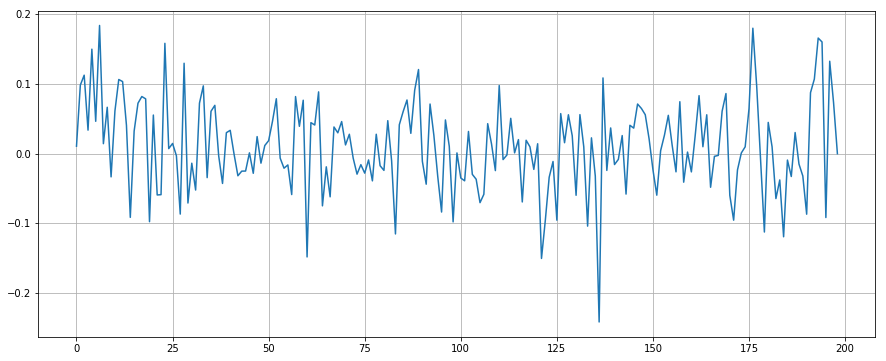

In [42]:
plt.figure(figsize = (15, 6))
plt.plot(modelIC[shiftedReturnTable.shape[0]-backTestDays+T:], )
plt.grid()
modelIC[-backTestDays+1:-1].mean()

In [141]:
factorReturnTable[:, -1][-backTestDays:][-3]

0.002958999503670859

In [112]:
modelIC[-backTestDays+1:-1]

array([ 0.01078374,  0.09851423,  0.11269707,  0.03382532,  0.15002666,
        0.04652368,  0.18405981,  0.0143953 ,  0.06664462, -0.03322234,
        0.06128525,  0.10651354,  0.10352377,  0.04079912, -0.09134811,
        0.03249442,  0.07247772,  0.08206507,  0.07872084, -0.09756113,
        0.05549557, -0.05920421, -0.05877368,  0.15842694,  0.00733142,
        0.01469801, -0.0029508 , -0.08663598,  0.12982887, -0.07076278,
       -0.0136241 , -0.05213662,  0.07257765,  0.09736464, -0.03431586,
        0.06092693,  0.06943986, -0.00304489, -0.04267376,  0.03018394,
        0.03357679, -0.00054314, -0.03166114, -0.02502049, -0.02487885,
        0.00122412, -0.02810147,  0.02455821, -0.01355459,  0.01176861,
        0.01874872,  0.04648207,  0.07891834, -0.00635099, -0.0207961 ,
       -0.01608731, -0.05862404,  0.08201391,  0.03931125,  0.07674919,
       -0.14816185,  0.04459624,  0.0411923 ,  0.08875243, -0.07483583,
       -0.0188127 , -0.06185861,  0.03836716,  0.02998469,  0.04